Homework set for chapter 8

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, minimize,minimize_scalar,root_scalar
from scipy.interpolate import CubicSpline,interp1d,InterpolatedUnivariateSpline
import time



In [75]:
gamma, beta, r, w = 0.5, 0.975, 0.02, 1
convergance_tolerance = 1e-6
Simulation_periods = 200  # number of periods
max_iterations = 2000
a_borrow = 5
# Model parameters
egam = 1 - 1 / gamma
# Grid parameters
a_l = -w / r
a_u = w / r
grid_a = np.linspace(a_l, a_u, 501)
a_l_borrowing = max(a_l, -a_borrow)




In [37]:
#8.4

def utility_function(c):
    return c**(1-1/gamma)/(1-1/gamma)

def marginal_utility(c):
    return c ** (-1 / gamma)

#initial guess interpolation
def inter_helper(a_grid,v_grid):
    return interp1d(a_grid,v_grid,kind='linear',fill_value='extrapolate')

#Bellmans equation
def bellman_equation(value_function,a):
    upper_bound = (1 + r) * a + w
    # If consumption is infeasible (upper_bound <= 0), assign a large negative value
    if upper_bound <= 1e-8:
        return -1e10, 1e-8
    
    def objective(c):
        if c <= 0:
            return -1e10
        next_a = (1+r)*a + w - c
        return - (utility_function(c) + beta * value_function(next_a))
    result = minimize_scalar(objective,bounds=(1e-10,upper_bound),method='bounded')
    return -result.fun, result.x

#Value function grid
initial_guess = np.zeros_like(grid_a) #initial guess (V)
policy_consumption_function = np.zeros_like(grid_a) #policy function (policy)

#VFI


for i in range(max_iterations):
    value_function = inter_helper(grid_a,initial_guess)
    initial_guess_new = np.zeros_like(initial_guess) #dummy array that will get dumped into the original policy function later. will now be used to store the new policy function 
    for j, a in enumerate(grid_a):
        initial_guess_new[j], policy_consumption_function[j] = bellman_equation(value_function,a)
    if np.max(np.abs(initial_guess - initial_guess_new)) < convergance_tolerance:
        break
    initial_guess = initial_guess_new.copy()

print(f"Converged after {i+1} iterations.")
print(f"Policy function: {policy_consumption_function}, Initial guess: {initial_guess}")


Converged after 500 iterations.
Policy function: [0.99999453 1.01503096 1.02157026 1.02668634 1.03106125 1.03496606
 1.03853381 1.04184819 1.04495855 1.04729416 1.04809951 1.05080023
 1.05361235 1.05629348 1.05886339 1.06134025 1.06373362 1.0660582
 1.06831683 1.07051951 1.07266801 1.07477012 1.07682879 1.07884728
 1.0808286  1.082777   1.08469141 1.08657596 1.08843265 1.09026309
 1.09206884 1.09385014 1.09560976 1.09734822 1.0990666  1.10076587
 1.10244693 1.10411062 1.10575769 1.10738878 1.10900464 1.11060604
 1.1121932  1.11376691 1.11532759 1.11623257 1.11703691 1.11841792
 1.11995541 1.12148259 1.12299872 1.12450152 1.12599422 1.12747709
 1.12894934 1.13041364 1.13186546 1.13330968 1.13474478 1.1361713
 1.13758931 1.13900046 1.1404027  1.14179731 1.14318455 1.14456512
 1.14593868 1.14730563 1.148666   1.15002001 1.15136457 1.15270693
 1.15404104 1.155371   1.15669422 1.15801161 1.15932473 1.16063245
 1.16193508 1.16322967 1.16452269 1.16580747 1.16709122 1.16836876
 1.16964164 1.1

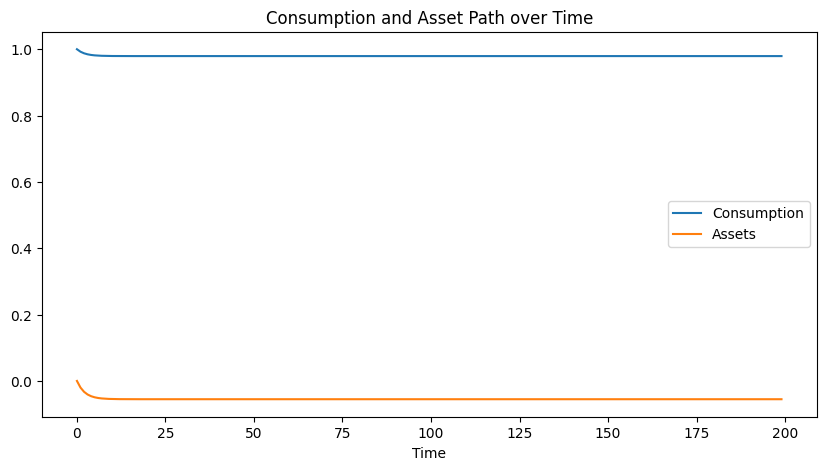

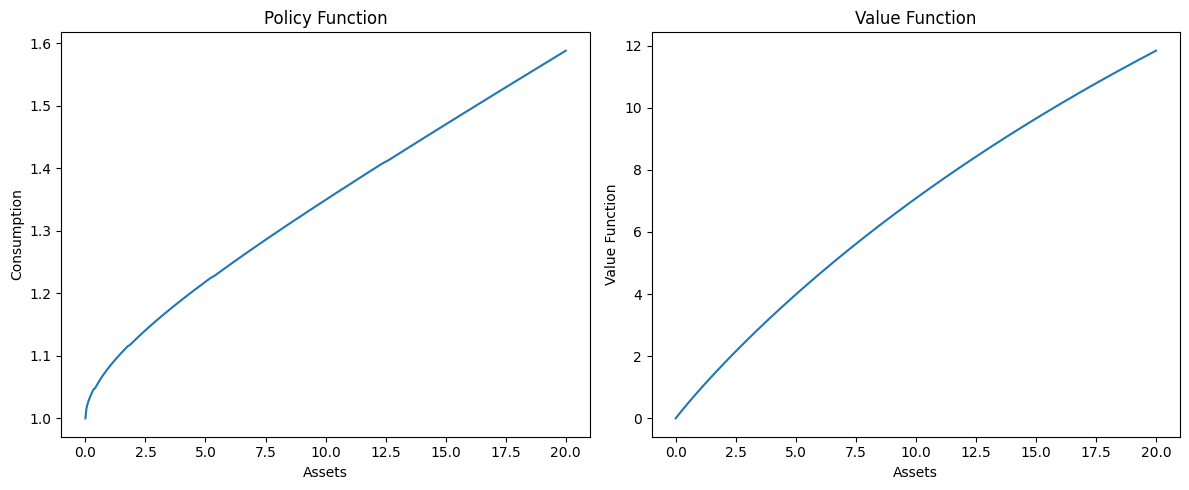

In [ ]:


periods = 200
assets = np.zeros(periods)
consumption_path = np.zeros(periods)

assets[0] = 0  # Starting assets
value_function = inter_helper(grid_a, initial_guess)
policy_function = interp1d(grid_a, policy_consumption_function, kind='linear', fill_value='extrapolate')

for t in range(periods):
    consumption_path[t] = policy_function(assets[t])
    if t < periods - 1:
        assets[t + 1] = (1 + r) * (assets[t] - consumption_path[t]) + w

plt.figure(figsize=(10, 5))
plt.plot(consumption_path, label='Consumption')
plt.plot(assets, label='Assets')
plt.xlabel('Time')
plt.legend()
plt.title('Consumption and Asset Path over Time')
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(grid_a, policy_consumption_function)
plt.xlabel('Assets')
plt.ylabel('Consumption')
plt.title('Policy Function')

plt.subplot(1, 2, 2)
plt.plot(grid_a, initial_guess-np.min(initial_guess))
plt.xlabel('Assets')
plt.ylabel('Value Function')
plt.title('Value Function')

plt.tight_layout()
plt.show()

Converged after 476 iterations


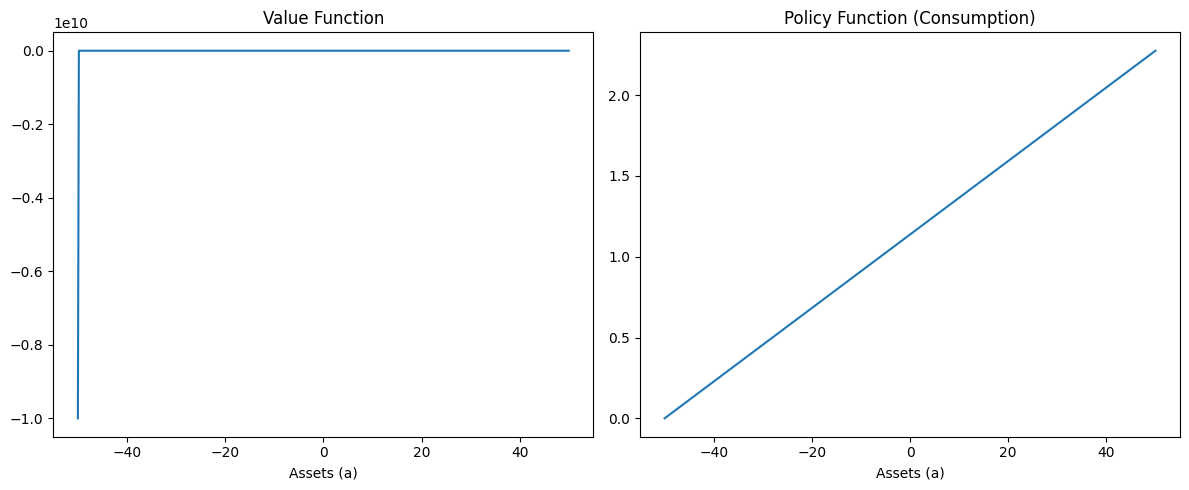

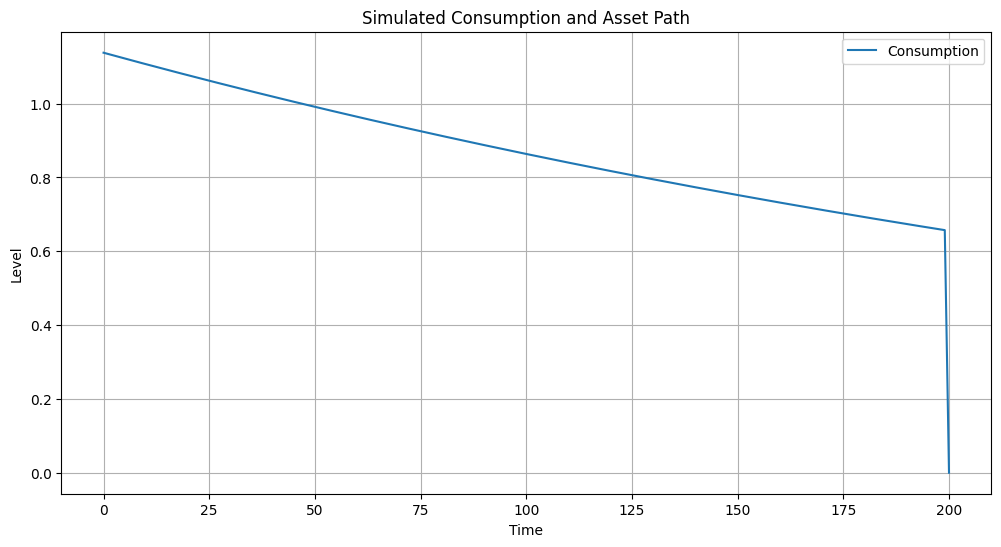

Time elapsed: 84.45 seconds


In [18]:
# Initialize arrays
c = (r * grid_a + w) / 2
V = np.zeros_like(grid_a)
V_new = np.zeros_like(grid_a)

# Utility function
def utility(x_in, i, spline_V):
    consumption = (1 + r) * grid_a[i] + w - x_in

    if consumption < 1e-10:
        penalty = -1e-10 ** egam / egam * (1 + abs(consumption))
        return penalty

    vplus = spline_eval(x_in, spline_V)
    vplus = max(vplus, 1e-10) ** egam / egam

    return - (consumption ** egam / egam + beta * vplus)

# Spline evaluation
def spline_eval(x, spline_V):
    return spline_V(x)

# Timer start
t0 = time.time()

# Main iteration
for iteration in range(max_iterations):

    # Boundary condition at a = a_l
    c[0] = 0.0
    V_new[0] = 1e-10 ** egam / egam

    # Interpolate value function for spline evaluation
    spline_V = InterpolatedUnivariateSpline(grid_a, np.maximum(egam * V, 1e-12) ** (1 / egam), k=3)

    for i in range(len(grid_a)):

        # Define the objective function for minimization
        obj = lambda x_in: utility(x_in, i, spline_V)

        # Bounds for optimization
        lower = a_l
        upper = min((1 + r) * grid_a[i] + w, a_u)

        # Initial guess
        x_guess = (1 + r) * grid_a[i] + w - c[i]

        res = minimize_scalar(obj, bounds=(lower, upper), method='bounded')

        x_in = res.x
        fret = res.fun

        # Optimal consumption and value
        c[i] = (1 + r) * grid_a[i] + w - x_in
        V_new[i] = -fret

    # Convergence check
    con_lev = np.max(np.abs(V_new - V) / np.maximum(np.abs(V), 1e-10))
    #print(f"Iteration {iteration+1:4d}, Convergence level: {con_lev:12.8f}")

    if con_lev < convergance_tolerance:
        print(f"Converged after {iteration+1} iterations")
        break

    V = V_new.copy()

else:
    print("No convergence")

# Plot results
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(grid_a, V)
plt.title("Value Function")
plt.xlabel("Assets (a)")

plt.subplot(1, 2, 2)
plt.plot(grid_a, c)
plt.title("Policy Function (Consumption)")
plt.xlabel("Assets (a)")

plt.tight_layout()
plt.show()

a_function = np.zeros(201)
c_function = np.zeros(201)
consumption_policy_function = InterpolatedUnivariateSpline(grid_a, c, k=3)
a_function[0] = 0
for i in range(200):
    current_assets = a_function[i]
    c_function[i] = consumption_policy_function(current_assets)
    a_function[i + 1] = (1 + r) * current_assets + w - c_function[i]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(201), c_function, label='Consumption')
plt.xlabel('Time')
plt.ylabel('Level')
plt.legend()
plt.title('Simulated Consumption and Asset Path')
plt.grid(True)
plt.show()

print(f"Time elapsed: {time.time() - t0:.2f} seconds")

Converged after 1 iterations


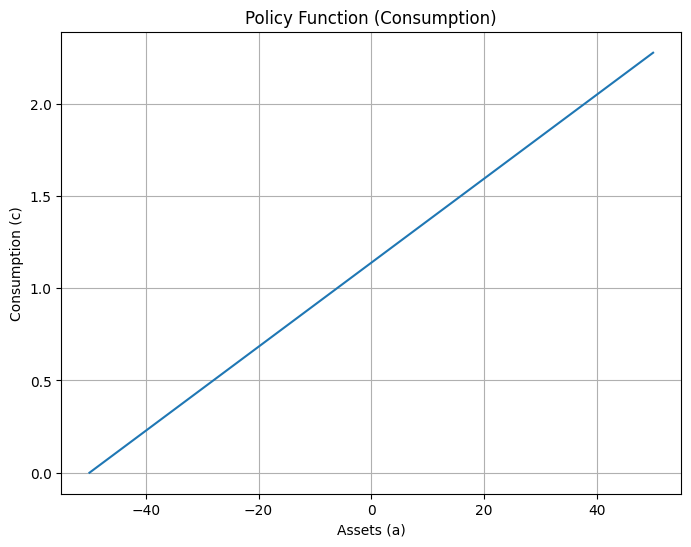

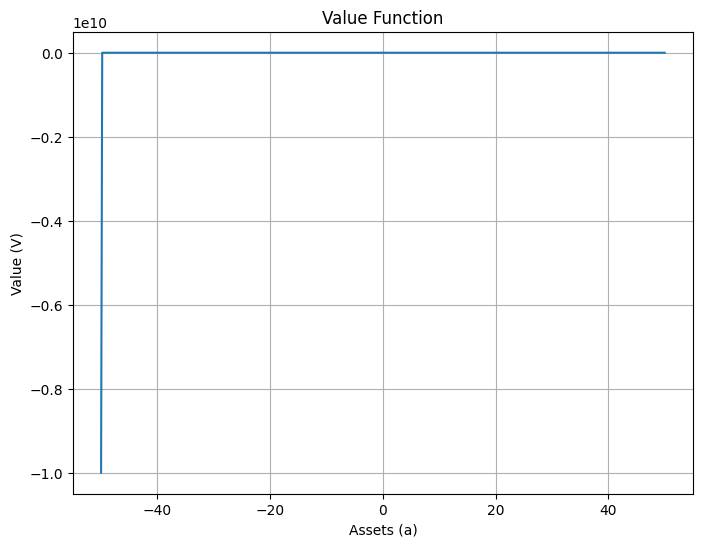

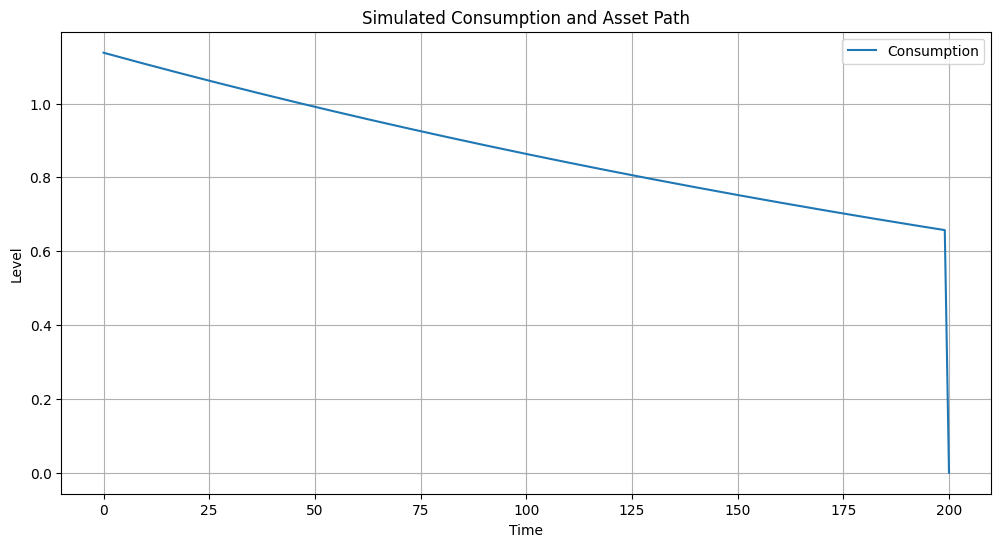

Time elapsed: 0.31 seconds


In [40]:
def foc(x_in, i, spline_c):
    """
    First-order condition for optimal consumption.
    """
    c_plus = spline_c(min(x_in, a_u))

    # Linear extrapolation if x_in > a_u
    if x_in > a_u:
        c_plus += (x_in - a_u) * (c[-1] - c[-2]) / (grid_a[-1] - grid_a[-2])

    return (1 + r) * grid_a[i] + w - x_in - (beta * (1 + r)) ** (-gamma) * c_plus

# Timer start
t0 = time.time()

# Main iteration
for iteration in range(max_iterations):

    # Boundary condition at a = a_l
    c[0] = 0.0

    # Interpolate consumption function for spline evaluation
    spline_c = InterpolatedUnivariateSpline(grid_a, c, k=3)

    c_new = np.zeros_like(c)

    for i in range(1, len(grid_a)):

        # Initial guess for root finding
        x_guess = (1 + r) * grid_a[i] + w - c[i]

        # Bounds for root finding
        lower = a_l
        upper = min((1 + r) * grid_a[i] + w, a_u + 1e-6)

        # Root finding for FOC
        sol = root_scalar(foc, args=(i, spline_c), bracket=(lower, upper), method='brentq')

        if not sol.converged:
            print(f"Root finding failed at iteration {iteration}, i = {i}")

        x_in = sol.root
        c_new[i] = (1 + r) * grid_a[i] + w - x_in

    con_lev = np.max(np.abs(c_new - c) / np.maximum(np.abs(c), 1e-10))
    #print(f"Iteration {iteration+1:4d}, Convergence level: {con_lev:12.8f}")

    if con_lev < convergance_tolerance:
        print(f"Converged after {iteration+1} iterations")
        break

    c = c_new.copy()
else:
    print("No convergence")

# Plot policy function
plt.figure(figsize=(8, 6))
plt.plot(grid_a, c)
plt.title("Policy Function (Consumption)")
plt.xlabel("Assets (a)")
plt.ylabel("Consumption (c)")
plt.grid(True)
plt.show()

#plot value function
plt.figure(figsize=(8, 6))
plt.plot(grid_a, V)
plt.title("Value Function")
plt.xlabel("Assets (a)")
plt.ylabel("Value (V)")
plt.grid(True)
plt.show()

# Simulate time path of consumption and assets
a_function = np.zeros(201)
c_function = np.zeros(201)
consumption_policy_function = InterpolatedUnivariateSpline(grid_a, c, k=3)
a_function[0] = 0
for i in range(200):
    current_assets = a_function[i]
    c_function[i] = consumption_policy_function(current_assets)
    a_function[i + 1] = (1 + r) * current_assets + w - c_function[i]

# Plot simulated path
plt.figure(figsize=(12, 6))
plt.plot(range(201), c_function, label='Consumption')
plt.xlabel('Time')
plt.ylabel('Level')
plt.legend()
plt.title('Simulated Consumption and Asset Path')
plt.grid(True)
plt.show()

print(f"Time elapsed: {time.time() - t0:.2f} seconds")


Iter   1, diff = 2.10e-02
Iter   2, diff = 2.08e-02
Iter   3, diff = 2.06e-02
Iter   4, diff = 2.03e-02
Iter   5, diff = 2.01e-02
Iter   6, diff = 1.99e-02
Iter   7, diff = 1.97e-02
Iter   8, diff = 1.94e-02
Iter   9, diff = 1.92e-02
Iter  10, diff = 1.90e-02
Iter  11, diff = 1.88e-02
Iter  12, diff = 1.85e-02
Iter  13, diff = 1.83e-02
Iter  14, diff = 1.81e-02
Iter  15, diff = 1.78e-02
Iter  16, diff = 1.76e-02
Iter  17, diff = 1.73e-02
Iter  18, diff = 1.71e-02
Iter  19, diff = 1.69e-02
Iter  20, diff = 1.66e-02
Iter  21, diff = 1.64e-02
Iter  22, diff = 1.61e-02
Iter  23, diff = 1.59e-02
Iter  24, diff = 1.57e-02
Iter  25, diff = 1.54e-02
Iter  26, diff = 1.52e-02
Iter  27, diff = 1.49e-02
Iter  28, diff = 1.47e-02
Iter  29, diff = 1.45e-02
Iter  30, diff = 1.42e-02
Iter  31, diff = 1.40e-02
Iter  32, diff = 1.37e-02
Iter  33, diff = 1.35e-02
Iter  34, diff = 1.33e-02
Iter  35, diff = 1.30e-02
Iter  36, diff = 1.28e-02
Iter  37, diff = 1.26e-02
Iter  38, diff = 1.23e-02
Iter  39, di

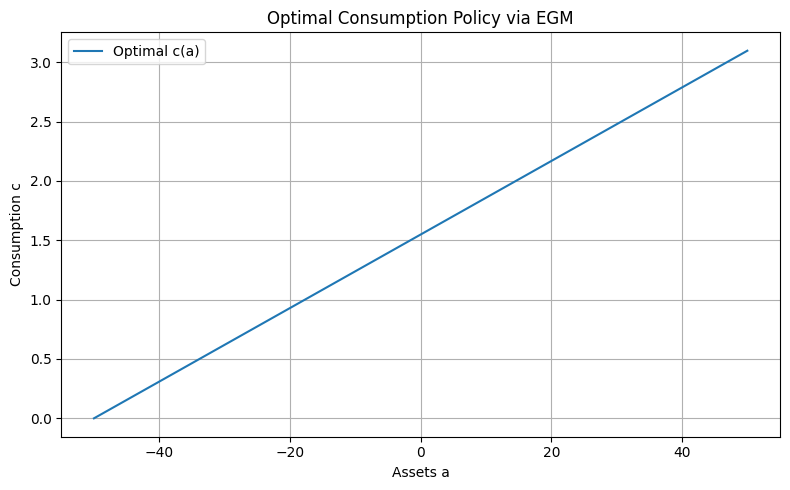

Elapsed time: 0.14s


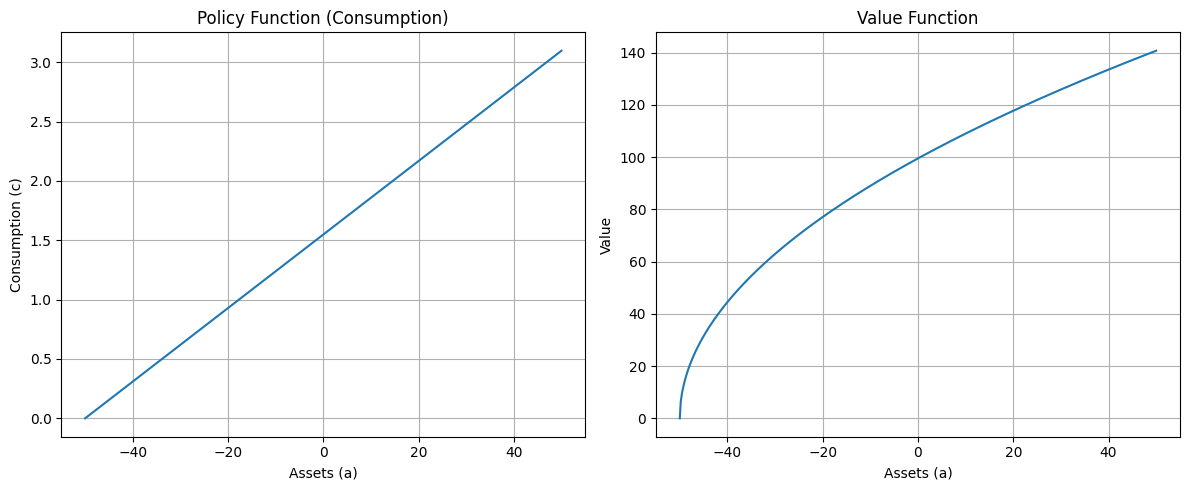

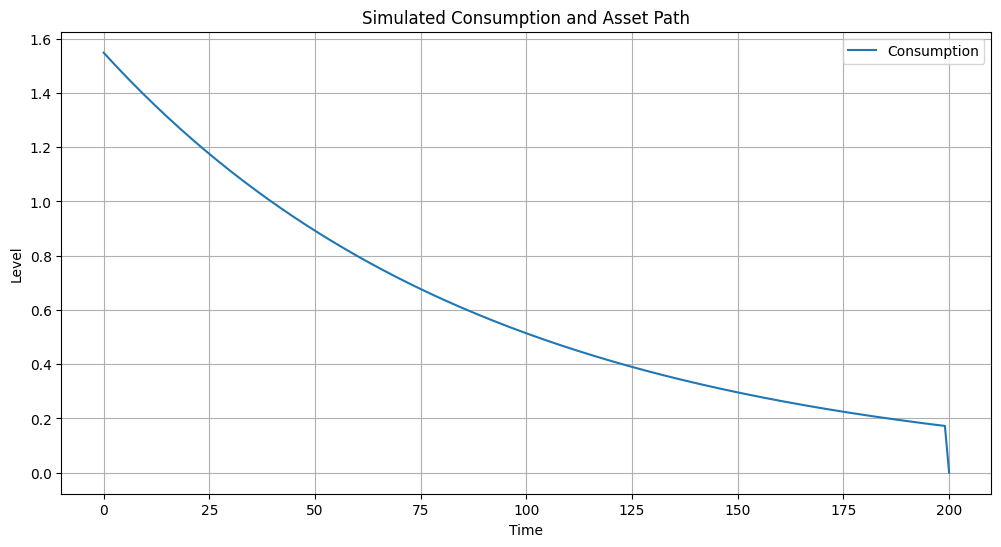

Time elapsed: 0.45 seconds


In [69]:

# CRRA utility inverse marginal – u'(c) = c^(-gamma) → inverse is c = mp^(-1/gamma)
def inv_marg_utility(mp):
    return mp ** (-1 / gamma)

# Timer start
t0 = time.time()

# Initialize policy guess: consumption = average income
c = (r * grid_a + w) / 2

for it in range(max_iterations):
    # Interpolated consumption function for next period
    spline_c = np.interp  # using numpy.interp is sufficient

    # Exogenous next-period grid and implied consumption
    grid_aplus = grid_a
    c_plus = np.maximum(spline_c(grid_aplus, grid_a, c, left=c[0], right=c[-1]), 1e-12)

    # Compute marginal utility next period
    mu_plus = c_plus ** (-gamma)

    # Invert Euler equation: c_current = (beta * (1+r) * mu_plus)^(-1/gamma)
    c_current = inv_marg_utility(beta * (1 + r) * mu_plus)

    # Endogenous current asset grid
    a_endog = (c_current + grid_aplus - w) / (1 + r)

    # Impose borrowing constraint: ensure monotonicity
    a_endog[0] = a_l
    c_current[0] = 0.0

    # Reinterpolate onto exogenous grid
    c_new = np.interp(grid_a, a_endog, c_current, left=0.0, right=c_current[-1])

    # Check for convergence
    diff = np.max(np.abs(c_new - c) / np.maximum(np.abs(c), 1e-10))
    print(f"Iter {it+1:3d}, diff = {diff:.2e}")
    if diff < convergance_tolerance:
        print(f"Converged after {it+1} iterations.")
        c = c_new
        break

    c = c_new
else:
    print("⚠️ No convergence within max iterations.")

# Plot the final policy function
plt.figure(figsize=(8, 5))
plt.plot(grid_a, c, label="Optimal c(a)")
plt.xlabel("Assets a")
plt.ylabel("Consumption c")
plt.title("Optimal Consumption Policy via EGM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Elapsed time: {time.time()-t0:.2f}s")



# ====== Compute Value Function ======
def utility(cons):
    """CRRA utility."""
    return (cons**(1 - gamma)) / (1 - gamma) if gamma != 1 else np.log(cons)

c_for_value = np.maximum(c, 1e-12)
V = utility(c_for_value) / (1 - beta)

# ====== Plot Policy Function and Value Function ======
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(grid_a, c)
ax[0].set_title("Policy Function (Consumption)")
ax[0].set_xlabel("Assets (a)")
ax[0].set_ylabel("Consumption (c)")
ax[0].grid(True)

ax[1].plot(grid_a, V)
ax[1].set_title("Value Function")
ax[1].set_xlabel("Assets (a)")
ax[1].set_ylabel("Value")
ax[1].grid(True)

plt.tight_layout()
plt.show()

# ====== Simulate Consumption and Asset Path ======
T = 200
a_sim = np.zeros(T + 1)
c_sim = np.zeros(T + 1)
c_func = interp1d(grid_a, c, kind='cubic', fill_value='extrapolate')

a_sim[0] = 0  # Initial assets
for t in range(T):
    c_sim[t] = np.maximum(c_func(a_sim[t]), 1e-12)
    a_sim[t + 1] = (1 + r) * a_sim[t] + w - c_sim[t]

# Plot the simulated paths
plt.figure(figsize=(12, 6))
plt.plot(range(T + 1), c_sim, label='Consumption')
plt.xlabel('Time')
plt.ylabel('Level')
plt.legend()
plt.title('Simulated Consumption and Asset Path')
plt.grid(True)
plt.show()

print(f"Time elapsed: {time.time() - t0:.2f} seconds")

No convergence


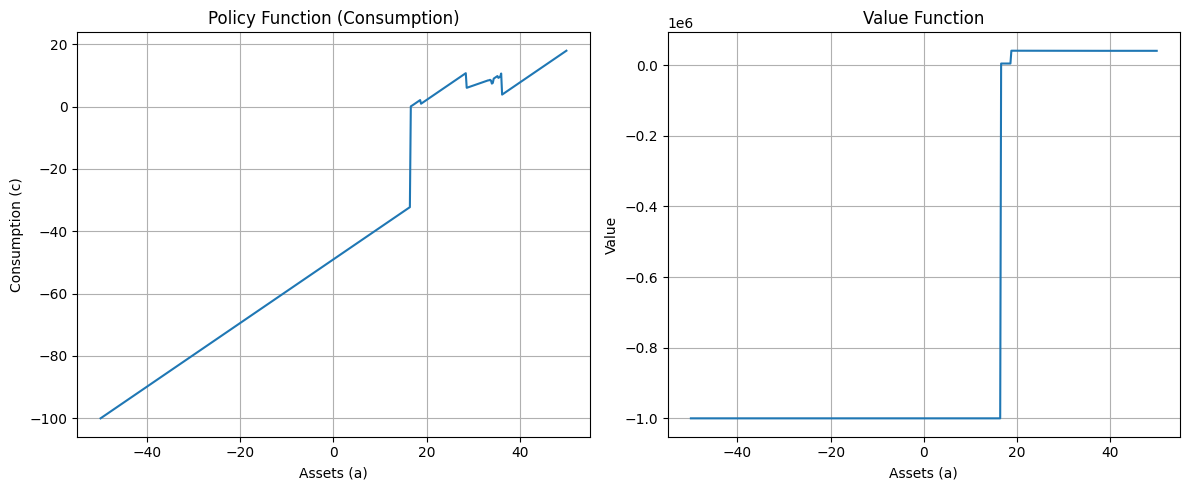

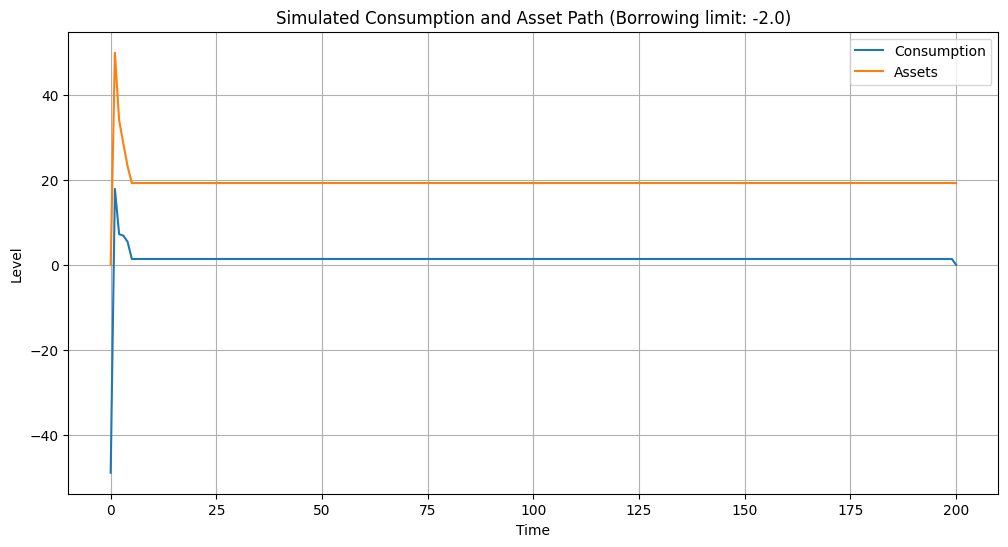

Time elapsed: 398.98 seconds


In [70]:
abar = 2.0         # Borrowing limit => a >= -abar

def present_utility(c):
    return c**egam / egam if c > 0 else -1e10

V = np.zeros_like(grid_a)

# Timer start
t0 = time.time()

for iteration in range(max_iterations):

    # Interpolate current value function
    spline_V = InterpolatedUnivariateSpline(grid_a, V, k=3)

    V_new = np.zeros_like(V)
    c_new = np.zeros_like(c)

    for i, a in enumerate(grid_a):

        def obj(a_next):
            c_now = (1 + r) * a + w - a_next
            if c_now <= 0:
                return 1e6  # Large penalty for infeasible consumption
            vplus = spline_V(a_next)
            return - (present_utility(c_now) + beta * vplus)

        bounds = (max(a_l, -abar), a_u)
        result = minimize_scalar(obj, bounds=bounds, method='bounded')
        a_star = result.x
        c_star = (1 + r) * a + w - a_star

        c_new[i] = c_star
        V_new[i] = -result.fun

    # Check convergence
    con_lev = np.max(np.abs(V_new - V) / np.maximum(np.abs(V), 1e-10))
    #print(f"Iteration {iteration+1:4d}, Convergence level: {con_lev:12.8f}")

    if con_lev < convergance_tolerance:
        print(f"Converged after {iteration+1} iterations")
        break

    V = V_new.copy()
    c = c_new.copy()

else:
    print("No convergence")

# Plot policy function and value function
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(grid_a, c)
ax[0].set_title("Policy Function (Consumption)")
ax[0].set_xlabel("Assets (a)")
ax[0].set_ylabel("Consumption (c)")
ax[0].grid(True)

ax[1].plot(grid_a, V)
ax[1].set_title("Value Function")
ax[1].set_xlabel("Assets (a)")
ax[1].set_ylabel("Value")
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Simulate consumption and asset path
a_sim = np.zeros(Simulation_periods + 1)
c_sim = np.zeros(Simulation_periods + 1)
consumption_func = InterpolatedUnivariateSpline(grid_a, c, k=3)

a_sim[0] = 0.0  # initial assets
for t in range(Simulation_periods):
    c_sim[t] = consumption_func(a_sim[t])
    a_next = (1 + r) * a_sim[t] + w - c_sim[t]
    a_sim[t + 1] = max(a_next, -abar)

# Plot simulated path
plt.figure(figsize=(12, 6))
plt.plot(range(T + 1), c_sim, label='Consumption')
plt.plot(range(T + 1), a_sim, label='Assets')
plt.xlabel('Time')
plt.ylabel('Level')
plt.legend()
plt.title(f'Simulated Consumption and Asset Path (Borrowing limit: {-abar})')
plt.grid(True)
plt.show()

print(f"Time elapsed: {time.time() - t0:.2f} seconds")

Converged after 434 iterations


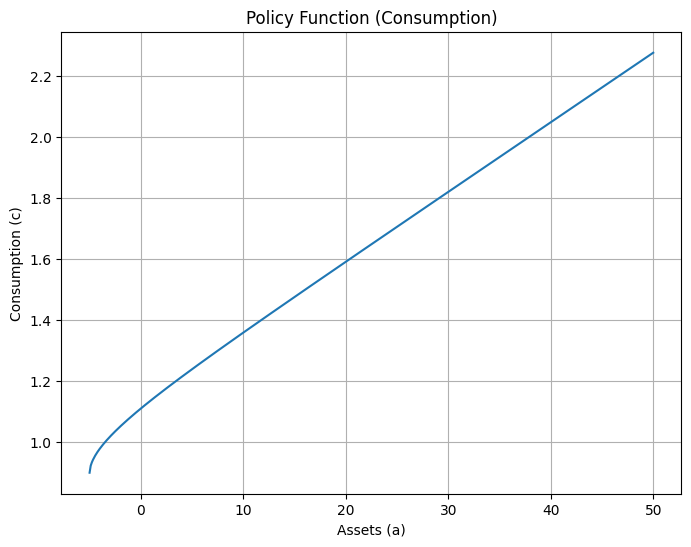

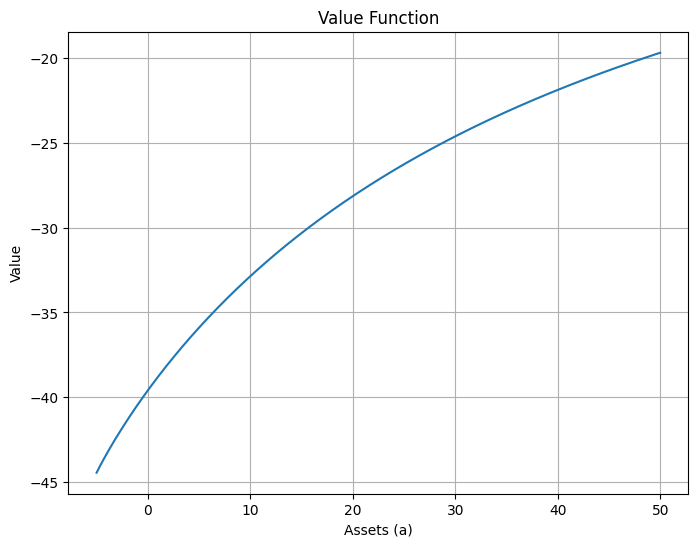

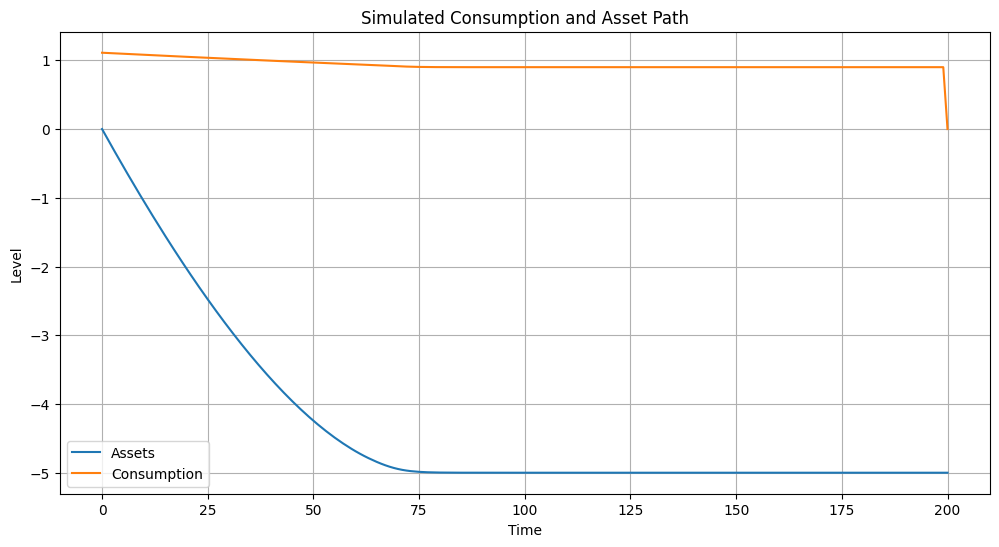

Time elapsed: 74.23 seconds


In [79]:
#I am repeating the parameters since I need to change the lower bound to account for borrowing limit
# Model parameters
gamma = 0.5
egam = 1.0 - 1.0 / gamma
beta = 0.975
r = 0.02
w = 1.0
a_borrow = 5.0  # Borrowing limit

# Numerical parameters
convergance_tolerance = 1e-6
max_iterations = 2000
Simulation_periods = 200

# Asset grid
a_l = max(-w / r, -a_borrow)
a_u = w / r
grid_a = np.linspace(a_l, a_u, 501)

# Initialize consumption and value function
c = (r * grid_a + w) / 2
V = np.zeros_like(grid_a)

# Timer start
t0 = time.time()

# Utility to minimize
def utility(x_in, i, spline_V):
    cons = (1 + r) * grid_a[i] + w - x_in

    if cons < 1e-10:
        return 1e10  # Strong penalty for infeasible consumption

    vplus = spline_V(x_in)
    vplus = max(vplus, 1e-10) ** egam / egam

    return - (cons ** egam / egam + beta * vplus)

# Main iteration
for iteration in range(max_iterations):

    # Interpolate value function for use in utility evaluation
    spline_V = InterpolatedUnivariateSpline(grid_a, np.maximum(egam * V, 1e-12) ** (1 / egam), k=3)

    V_new = np.empty_like(V)

    for i in range(len(grid_a)):

        bounds = (a_l, min((1 + r) * grid_a[i] + w, a_u))

        res = minimize_scalar(lambda x: utility(x, i, spline_V), bounds=bounds, method='bounded')

        x_in = res.x
        fret = res.fun

        c[i] = (1 + r) * grid_a[i] + w - x_in
        V_new[i] = -fret

    # Convergence check
    con_lev = np.max(np.abs(V_new - V) / np.maximum(np.abs(V), 1e-10))
    #print(f"Iteration {iteration+1:4d}, Convergence level: {con_lev:12.8f}")

    if con_lev < convergance_tolerance:
        print(f"Converged after {iteration+1} iterations")
        break

    V = V_new.copy()

else:
    print("No convergence")

# Plot policy function
plt.figure(figsize=(8, 6))
plt.plot(grid_a, c)
plt.title("Policy Function (Consumption)")
plt.xlabel("Assets (a)")
plt.ylabel("Consumption (c)")
plt.grid(True)
plt.show()

# Plot value function
plt.figure(figsize=(8, 6))
plt.plot(grid_a, V)
plt.title("Value Function")
plt.xlabel("Assets (a)")
plt.ylabel("Value")
plt.grid(True)
plt.show()

# Simulate consumption and asset path
a_t = np.zeros(Simulation_periods + 1)
c_t = np.zeros(Simulation_periods + 1)
c_policy = InterpolatedUnivariateSpline(grid_a, c, k=3)

a_t[0] = 0.0
for t in range(Simulation_periods):
    c_t[t] = c_policy(a_t[t])
    a_t[t+1] = (1 + r) * a_t[t] + w - c_t[t]

# Plot time path
plt.figure(figsize=(12, 6))
plt.plot(range(Simulation_periods + 1), a_t, label="Assets")
plt.plot(range(Simulation_periods + 1), c_t, label="Consumption")
plt.xlabel("Time")
plt.ylabel("Level")
plt.legend()
plt.title("Simulated Consumption and Asset Path")
plt.grid(True)
plt.show()

print(f"Time elapsed: {time.time() - t0:.2f} seconds")

Root finding failed at iteration 0, i = 1
Root finding failed at iteration 0, i = 2
Root finding failed at iteration 0, i = 3
Root finding failed at iteration 0, i = 4
Root finding failed at iteration 0, i = 5
Root finding failed at iteration 0, i = 6
Root finding failed at iteration 0, i = 7
Root finding failed at iteration 0, i = 8
Root finding failed at iteration 0, i = 9
Root finding failed at iteration 0, i = 10
Root finding failed at iteration 0, i = 11
Root finding failed at iteration 0, i = 12
Root finding failed at iteration 0, i = 13
Root finding failed at iteration 0, i = 14
Root finding failed at iteration 0, i = 15
Root finding failed at iteration 0, i = 16
Root finding failed at iteration 0, i = 17
Root finding failed at iteration 0, i = 18
Root finding failed at iteration 0, i = 19
Root finding failed at iteration 0, i = 20
Root finding failed at iteration 0, i = 21
Root finding failed at iteration 0, i = 22
Root finding failed at iteration 0, i = 23
Root finding failed 

C:\Users\oluri\AppData\Local\Temp\ipykernel_18640\3061676988.py:34: RuntimeWarning: invalid value encountered in power
  mu_plus = c_plus ** (-gamma)
C:\Users\oluri\AppData\Local\Temp\ipykernel_18640\3061676988.py:76: RuntimeWarning: divide by zero encountered in reciprocal
  V = (c ** egam) / egam


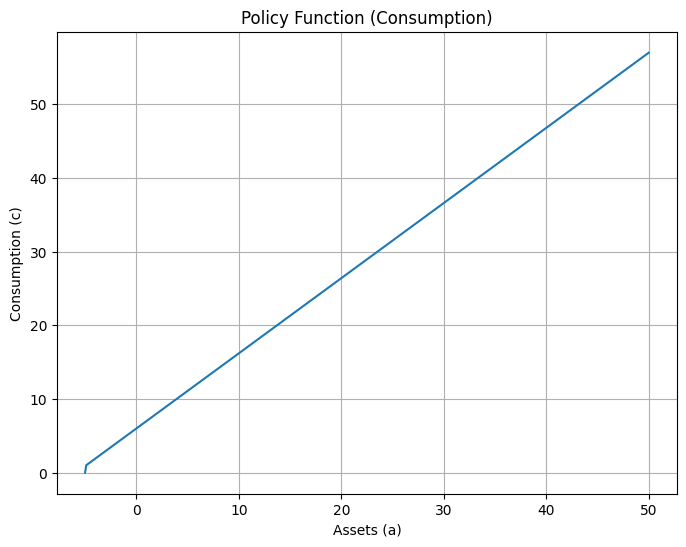

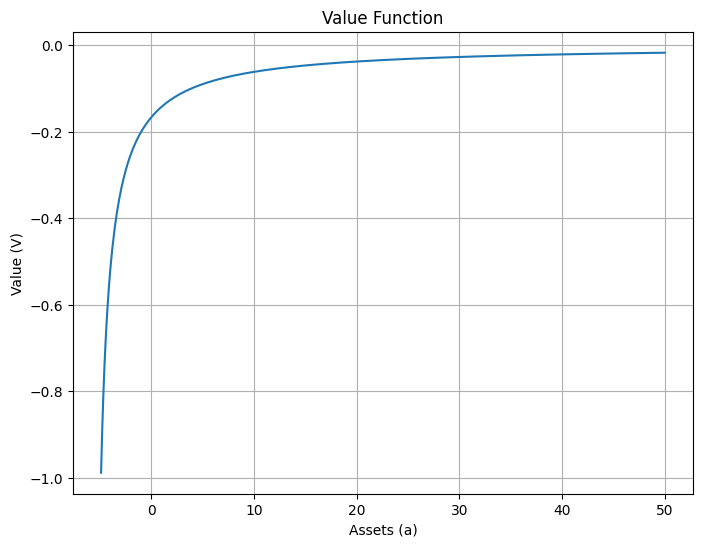

Time elapsed: 0.21 seconds


In [81]:
#repeating parameters to ensure borrowing constraint is respected
# Model parameters
abar = 5.0    # Borrowing limit
gamma = 0.5
beta = 0.975
r = 0.02
w = 1.0

# Numerical parameters
convergance_tolerance = 1e-6
max_iterations = 2000
a_l = max(-w / r, -abar)
a_u = w / r
grid_a = np.linspace(a_l, a_u, 501)

# Initialize consumption and value function
c = (r * grid_a + w) / 2
V = np.zeros_like(c)

# Timer start
t0 = time.time()

def foc(x_in, i, spline_c):
    """
    First-order condition (FOC) for optimal consumption.
    """
    if x_in <= a_u:
        c_plus = spline_c(x_in)
    else:
        # Linear extrapolation for c_plus beyond the grid
        slope = (c[-1] - c[-2]) / (grid_a[-1] - grid_a[-2])
        c_plus = c[-1] + slope * (x_in - a_u)

    mu_plus = c_plus ** (-gamma)
    return (1 + r) * grid_a[i] + w - x_in - (beta * (1 + r)) ** (-gamma) * mu_plus

# Main iteration
for iteration in range(max_iterations):

    # Boundary condition at a = a_l
    c[0] = 0.0

    # Interpolate consumption function
    spline_c = InterpolatedUnivariateSpline(grid_a, c, k=3)

    c_new = np.zeros_like(c)

    for i in range(1, len(grid_a)):

        # Bounds for root finding, respecting borrowing constraint
        lower = max(-abar, a_l)
        upper = min((1 + r) * grid_a[i] + w, a_u + 1e-8)

        # Root finding for FOC
        sol = root_scalar(foc, args=(i, spline_c), bracket=(lower, upper), method='brentq')

        if not sol.converged:
            print(f"Root finding failed at iteration {iteration}, i = {i}")

        x_in = sol.root
        c_new[i] = (1 + r) * grid_a[i] + w - x_in

    con_lev = np.max(np.abs(c_new - c) / np.maximum(np.abs(c), 1e-10))
    #print(f"Iteration {iteration+1:4d}, Convergence level: {con_lev:12.8f}")

    if con_lev < convergance_tolerance:
        print(f"Converged after {iteration+1} iterations")
        break

    c = c_new.copy()
else:
    print("No convergence")

# Value function approximation
egam = 1 - 1 / gamma
V = (c ** egam) / egam

# Plot policy function (consumption)
plt.figure(figsize=(8, 6))
plt.plot(grid_a, c)
plt.title("Policy Function (Consumption)")
plt.xlabel("Assets (a)")
plt.ylabel("Consumption (c)")
plt.grid(True)
plt.show()

# Plot value function
plt.figure(figsize=(8, 6))
plt.plot(grid_a, V)
plt.title("Value Function")
plt.xlabel("Assets (a)")
plt.ylabel("Value (V)")
plt.grid(True)
plt.show()

# Simulate time path of consumption and assets
TT = 200
a_sim = np.zeros(TT + 1)
c_sim = np.zeros(TT + 1)
consumption_policy_function = InterpolatedUnivariateSpline(grid_a, c, k=3)
a_sim[0] = 0.0

for t in range(TT):
    current_assets = a_sim[t]
    c_sim[t] = consumption_policy_function(np.clip(current_assets, grid_a[0], grid_a[-1]))
    a_next = (1 + r) * current_assets + w - c_sim[t]
    a_sim[t + 1] = max(a_next, -abar)  # Enforce borrowing constraint in simulation



print(f"Time elapsed: {time.time() - t0:.2f} seconds")

Converged after 162 iterations.


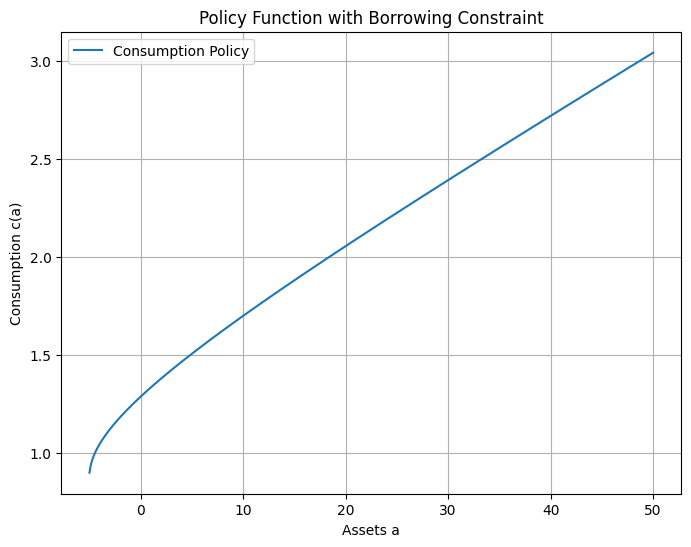

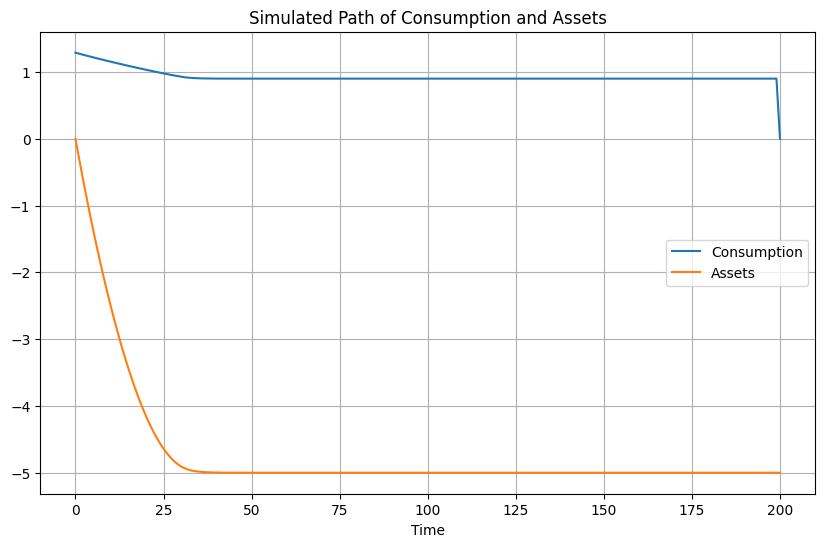

Elapsed time: 1042.96 seconds


In [93]:
c = (r * grid_a + w) / 2
grid_a = np.linspace(a_l, a_u, 501)

for iteration in range(max_iterations):
    # Step 1: compute c_plus from current policy guess
    spline_c = interp1d(grid_a, c, fill_value="extrapolate")
    c_plus = spline_c(grid_a)

    # Step 2: compute marginal utility and invert Euler equation
    mu_plus = np.maximum(c_plus, 1e-12) ** (-gamma)
    c_current = (beta * (1 + r) * mu_plus) ** (-1 / gamma)

    # Step 3: endogenous asset grid implied by budget constraint
    a_endog = (c_current + grid_a - w) / (1 + r)

    # Step 4: Handle constrained region explicitly
    # Where endogenous asset < borrowing limit → use corner solution
    constrained = a_endog < a_l
    unconstrained = ~constrained

    # Consumption at the borrowing constraint
    c_constraint = (1 + r) * grid_a[constrained] + w - a_l

    # Combine constrained and unconstrained parts for interpolation
    if np.any(unconstrained):
    # Normal case: mix constrained and unconstrained
        a_combined = np.concatenate(([a_l], a_endog[unconstrained]))
        c_combined = np.concatenate(([ (1 + r) * a_l + w - a_l ], c_current[unconstrained]))
    else:
    # Extreme case: everything is constrained → use only constrained consumption
        a_combined = np.array([a_l, a_u])
        c_val = (1 + r) * a_l + w - a_l
        c_combined = np.array([c_val, c_val])  # constant consumption at borrowing limit

    # Step 5: interpolate consumption back to original grid
    c_new = np.interp(grid_a, a_combined, c_combined, left=c_combined[0], right=c_combined[-1])

    # Step 6: check convergence
    diff = np.max(np.abs(c_new - c) / np.maximum(c, 1e-8))
    if diff < convergance_tolerance:
        print(f"Converged after {iteration+1} iterations.")
        break

    c = c_new.copy()
else:
    print("Did not converge.")

# Plot consumption policy
plt.figure(figsize=(8, 6))
plt.plot(grid_a, c, label='Consumption Policy')
plt.xlabel('Assets a')
plt.ylabel('Consumption c(a)')
plt.title('Policy Function with Borrowing Constraint')
plt.grid(True)
plt.legend()
plt.show()

# Simulate consumption and asset path
T_sim = 200
a_sim = np.zeros(T_sim + 1)
c_sim = np.zeros(T_sim + 1)
a_sim[0] = 0.0

for t in range(T_sim):
    c_sim[t] = np.interp(a_sim[t], grid_a, c)
    a_sim[t+1] = (1 + r) * a_sim[t] + w - c_sim[t]
    a_sim[t+1] = max(a_sim[t+1], a_l)  # Enforce borrowing limit

plt.figure(figsize=(10, 6))
plt.plot(range(T_sim + 1), c_sim, label='Consumption')
plt.plot(range(T_sim + 1), a_sim, label='Assets')
plt.xlabel('Time')
plt.title('Simulated Path of Consumption and Assets')
plt.legend()
plt.grid(True)
plt.show()

print(f"Elapsed time: {time.time() - t0:.2f} seconds")